<a href="https://colab.research.google.com/github/BastienBoucherat/geo6149/blob/main/geo6149_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Etude de la capacité théorique d'autonomie alimentaire du territoire**
---

GEO-6149: Géomatique

*   Bastien Boucherat (20155314)
*   Juliette Goulet ()


# **Configuration de l'environnement de travail**
*    Création des dossiers sur Google Colab
*    Installation de paquets python additionnels
*    Importation des paquets python nécessaires
*    Récupération des données distantes

## Quelques définitions utiles (1)

Définitions relatives à l'analyse géomatique

In [1]:
# Coordinate system for Latitude-Longitude
geo_crs = 'EPSG:4326'

# Projection used for plots (web Mercator)
plot_crs = 'EPSG:3857'

# Coordinate system used throughout the study
study_crs = 'EPSG:32188'

Définitions relatives à la gestion des fichiers sur Google Colab

In [2]:
# This folder is the projet root folder in Google Colab
project_folder = "/content"

# This folder will contain any temporary files
tmp_folder = project_folder + "/tmp"

# This folder will contain persistent data
data_folder = project_folder + "/data"

# This folder will contain generated outputs
output_folder = project_folder + "/output"

## Arborescence des dossiers
Création de quelques dossiers de travail sur Google Colab.

In [3]:
# Packages necessary to handle files in Google Colab.
# https://docs.python.org/3/library/os.path.html
import os
import os.path

# Create folder is not already there (tmp)
if not os.path.exists(tmp_folder):
    os.mkdir(tmp_folder)

# Create folder is not already there (data)
if not os.path.exists(data_folder):
    os.mkdir(data_folder)

# Create folder is not already there (output)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

## Installation des paquets

Installation de paquets pour le **traitement des données géospatiales**.

In [4]:
# Install Geopandas
%%capture
!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
import os
os.chdir('spatialindex-src-1.8.5')
!./configure
!make
!make install
!pip install rtree
!ldconfig
!pip install geopandas

Installation de paquets pour le **traitement des données matricielles**.

In [5]:
# Install rasterIO
%%capture
!pip install rasterio

Installation de paquets pour la **visualisation des données**.

In [47]:
# Install packages for data visualisation
%%capture
!pip install contextily
!pip install mapclassify

## Importation des paquets

In [7]:
# Data processing
import numpy as np
import pandas as pd

In [275]:
# Geodata processing
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import geopy

In [9]:
# Data format
import json

In [10]:
# Data visualisation
import matplotlib.pyplot as plt
import contextily as cx
import seaborn as sns

## Chargement des données distantes

*   Chargement de la configuration des sources de données
*   Téléchargement des données distantes
*   Extraction des archives compressées (au besoin)
*   Sauvegarde des fichiers nécessaires
*   Suppression des fichiers inutiles

### Configuration des sources
La configuration est contenue dans un fichier de description des sources de donnnées distantes

In [11]:
# Load remote data sources information
data_sources_df = pd.read_csv(project_folder + '/data_sources.csv')
data_sources_df['Year'] = pd.to_datetime(data_sources_df['Year'], format="%Y").dt.year

# Download only from selected data sources
data_sources_df = data_sources_df[data_sources_df['Use?']==True]

### Copie des données distantes

In [12]:
%%capture

# Remote files will be downloaded and extracted in this folder
# Then, downloaded files will be used to generate pre-processed data files eventually stored locally in another folder
%cd {tmp_folder}

# For selected each source
for idx, data_source in data_sources_df.iterrows():

    # This will point to the useful file to save
    useful_file = ''

    # Get some information from the link
    data_file = data_source['Link'].split('/')[-1]
    data_file_name = data_file.split('.')[0]
    data_file_type = data_file.split('.')[-1] # file extension
    
    # Download source from internet
    if not os.path.exists(data_file):
        source_url = data_source['Link']
        # wget [URL] -P [Directory]
        !wget $source_url
    
    # Extract (if applicable)
    if data_file_type.lower() in ['zip']:

        # Where?
        extract_folder = data_file_name
 
        # Extract
        !unzip -u $data_file -d $extract_folder

        # Save path to file
        useful_file= useful_file + f"{extract_folder}/{data_source['File Name']}"
    else:
        # Save path to file
        useful_file = data_file_name

    # Save the useful files to a persistent folder

    # Shapefile
    if data_source['Format'] == 'shapefile':

        # List of desired file types
        file_types = ['shp','shx','dbf','prj']

        # Target files
        target_file = f"{data_folder}/{data_source['Type']}_{data_source['Area']}"

        # Copy all necessary files
        for file_type in file_types:
            src_file = f'{useful_file}.{file_type}'
            dest_file = f'{target_file}.{file_type}'
            !cp $src_file $dest_file

        # Save the data location
        data_sources_df.at[data_source['index'],'Location'] = f'{target_file}.shp'
    
    # Geotiff
    elif data_source['Format'] == 'geotiff':
        
        # List of desired file types
        file_types = ['tif','tiff']

        # Target files
        target_file = f"{data_folder}/{data_source['Type']}_{data_source['Area']}"
        print(f"Target file: {target_file}")

        # Try for every potentiel type of file
        for file_type in file_types:

            src_file = f'{useful_file}.{file_type}'
            print(f"Target file: {src_file}")
            # Copy every file that is found
            if os.path.exists(src_file):
                dest_file = f'{target_file}.{file_type}'
                dest_file_type = file_type
                !cp $src_file $dest_file
        
        # Save the data location
        data_sources_df.at[data_source['index'],'Location'] = f'{target_file}.{dest_file_type}'

### Nettoyage des fichiers temporaires


In [13]:
# Remove temporary files
if True:
    # Remove files from extraction folders
    command = f'{tmp_folder}/*/*'
    !rm $command
    # Remove extraction folders themselves
    command = f'{tmp_folder}/*'
    !rmdir $command

# Remove downloaded source files
if False:
    # Remove zip files
    command = f'{tmp_folder}/*.zip'
    !rm $command

# Remove useless columns from data source description
data_sources_df = data_sources_df.drop(['Link', 'Use?', 'File Name'], axis='columns')

rmdir: failed to remove '/content/tmp/CanadaLandcover2015.zip': Not a directory
rmdir: failed to remove '/content/tmp/cb_2018_us_state_500k.zip': Not a directory
rmdir: failed to remove '/content/tmp/lpr_000b16a_e.zip': Not a directory
rmdir: failed to remove '/content/tmp/ppp_2020_1km_Aggregated.tif': Not a directory


In [14]:
# Export updated data sources information
data_sources_df.to_csv(output_folder + '/data_sources.csv')

# **Préparation des données génériques**

## Données administratives

**Chargement des frontières administratives** (Etats-Unis)

In [15]:
# Select US boundaries
file_name = data_sources_df[(data_sources_df['Type'] == 'Boundaries') & (data_sources_df['Area'] == 'USA')]['Location'].item()

# Load vector data
us_boundaries_gdf = gpd.read_file(file_name)

# Check coordinate system
if us_boundaries_gdf.crs == 'None':
    print("Error: CRS information is missing")
else:
    us_boundaries_gdf = us_boundaries_gdf.to_crs(study_crs)

# Cherry-pick and rename information
us_boundaries_gdf['NATION_ID']="USA"
us_boundaries_gdf = us_boundaries_gdf.rename(columns={'STUSPS':'SUB_NATION_ID','NAME':'SUB_NATION_NAME'})
us_boundaries_gdf = us_boundaries_gdf[['NATION_ID', 'SUB_NATION_ID', 'SUB_NATION_NAME', 'geometry']]

In [16]:
# States that are outside North American continent: Samoa, Virgin Islands, Guam, Mariana Islands, Hawai, Puerto Rico
outside_states = ['AS','VI','GU', 'MP', 'HI', 'PR']

# Remove states outisde of North America
us_boundaries_gdf = us_boundaries_gdf[~us_boundaries_gdf['SUB_NATION_ID'].isin(outside_states)]

**Chargement des frontières administratives** (Canada)

In [17]:
# Select Canada boundaries
file_name = data_sources_df[(data_sources_df['Type'] == 'Boundaries') & (data_sources_df['Area'] == 'Canada')]['Location'].item()

# Load vector data
can_boundaries_gdf = gpd.read_file(file_name)

# Check coordinate system
if can_boundaries_gdf.crs == 'None':
    print("Error: CRS is missing")
else:
    can_boundaries_gdf = can_boundaries_gdf.to_crs(study_crs)

# Cherry-pick and rename information
can_boundaries_gdf['NATION_ID']="CAN"
can_boundaries_gdf = can_boundaries_gdf.rename(columns={'PREABBR':'SUB_NATION_ID','PRENAME':'SUB_NATION_NAME'})
can_boundaries_gdf = can_boundaries_gdf[['NATION_ID', 'SUB_NATION_ID', 'SUB_NATION_NAME', 'geometry']]

**Sauvegarde des donnnées administratives** (Canada et Etat-Unis)

In [18]:
# Merge data for Canada+USA
boundaries_gdf = us_boundaries_gdf.append(can_boundaries_gdf)

# Define index
boundaries_gdf.set_index(['NATION_ID', 'SUB_NATION_ID'], inplace=True)

<ipython-input-18-733300387243>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  boundaries_gdf = us_boundaries_gdf.append(can_boundaries_gdf)


In [19]:
# Geometries from Statistiques Canada are really precise, hence very heavy.
# Let's make data lighter: this is done on all boundaries (US and Canada) so that precision is consistent across data
minimum_distance_km = 10
boundaries_gdf['geometry'] = boundaries_gdf['geometry'].simplify(minimum_distance_km*1000, preserve_topology = 'True')

In [20]:
# Save as a file
pd.DataFrame(boundaries_gdf).to_csv(output_folder + '/Boundaries.csv')

# **Analyse préliminaire pour le Québec**
Il s'agit ici d'effectuer quelques calculs simples pour le Québec afin de vérifier que notre manipulation des structures de données est correcte.

In [21]:
# Extract the geodataframe for Quebec
qc_gdf = boundaries_gdf.loc[[('CAN','Que.')]]

**Population du Québec**

In [22]:
# Load the population raster
pop_raster = rasterio.open(f'{data_folder}/Population_World.tif')

# Check coordinate system
if pop_raster.crs == 'None':
    print("Warning: loaded raster is missing CRS")

# Create mask for Quebec
qc_mask = [json.loads(qc_gdf.to_crs(pop_raster.crs).to_json())['features'][0]['geometry']]

# Extract the population data for Quebec from clipped raster
qc_pop_data = rasterio.mask.mask(pop_raster, qc_mask, crop=True)[0]

# Compute the total population of Quebec
print(f"There are around {round(sum(qc_pop_data[qc_pop_data>=0])/1e6,1)} million inhabitants in Quebec")

There are around 7.9 million inhabitants in Quebec


# **Définition de la zone d'étude**

Définition d'une fonction pour récupérer les coordonnées géographiques d'une liste de lieux à partir de leur nom.

In [366]:
from geopy.geocoders import Nominatim
################################################################################
# get_coordinates
################################################################################
def get_coordinates(places_list):

    # List of coordinates
    place_coordinates=[]

    # Specify a custom user agent
    geopy.geocoders.options.default_user_agent = "find_coordinates"

    # Create a geocoder object
    geolocator = Nominatim(user_agent="find_coordinates")

    # Loop through the list of city names
    for place in places_list:
        # Send request
        location = geolocator.geocode(place + ', Quebec, Canada')

        # Parse result
        if location:
            lat = location.latitude
            lon = location.longitude
            place_coordinates.append([lon, lat])

    return place_coordinates

## Centre de la zone d'étude

Définition du centre de notre zone d'étude.



In [369]:
from shapely.geometry import Point

# Set coordinates of the center of the study zone
center_coordinates = get_coordinates(["Montreal"])

# Create geometries from coordinates
center_geometry = [Point(center_coordinates)]

# Save information as geodataframe alongside the geometry
center_gdf = gpd.GeoDataFrame({'Name': 'Center', 'geometry': center_geometry}, geometry='geometry')

# Provide the coordinate system
center_gdf.crs = geo_crs

# Project to the desired CRS
center_gdf = center_gdf.to_crs(study_crs)

## Etendue de la zone d'étude

In [370]:
# Size of the study perimeter
study_radius_km = 300

# Create study perimeter as a buffer around the center
study_perimeter = center_gdf.buffer(study_radius_km*1e3, resolution=16)

# Create geodataframe from geometry
study_gdf = gpd.GeoDataFrame(geometry=study_perimeter)

# Provide the CRS with which is was created
study_gdf.crs = study_crs

On exporte un fichier geojson de la zone d'étude pour sauvegarde:

In [371]:
# Save the geometry as geoJSON
# geoJSON format requires EPSG:4326
file_name = "Perimeter_study.geojson"
study_gdf.to_crs(geo_crs).to_file(f'{output_folder}/{file_name}', driver='GeoJSON')

On affiche la zone d'étude pour vérifier que tout semble correct:

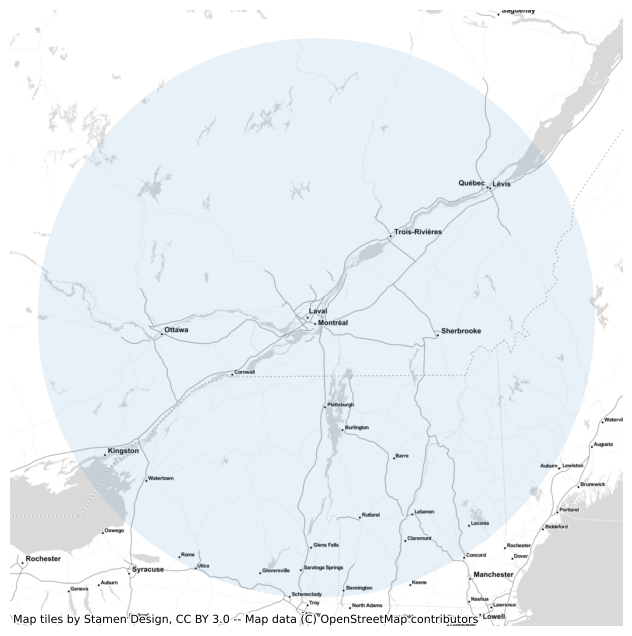

In [372]:
# Create a layer containing the study area
layer_1 = study_gdf.to_crs(plot_crs).plot(alpha=0.1, figsize=(8, 8))

# Beautify https://geopandas.org/en/stable/gallery/plotting_basemap_background.html
cx.add_basemap(layer_1, source=cx.providers.Stamen.TonerLite, zoom=8)
layer_1.set_axis_off()

# **Préparation des données pour la zone d'étude**
*   Application du masque aux données d'entrée de population
*   Application du masque aux données d'entrée agricoles

## Population (données matricielles)

In [27]:
# Population raster file
file_name = 'Population_World.tif'

# Load population raster
pop_raster = rasterio.open(f'{data_folder}/{file_name}')

# Check coordinate system
if pop_raster.crs == 'None':
    print("Warning: loaded raster is missing CRS")

In [28]:
# Create a mask corresponding to the study area in the raster's coordinate system
study_mask = [json.loads(study_gdf.to_crs(pop_raster.crs).to_json())['features'][0]['geometry']]

# Clip the raster with the mask
# The clipped output loses the geospatial information
# So we also save the geospatial information alongside
study_pop_np, study_pop_transform = rasterio.mask.mask(pop_raster, study_mask, crop=True)

# Reintegrate geopspatial information
study_pop_metadata = pop_raster.meta # reuse the metadata from the original file
study_pop_metadata.update({"driver": "GTiff",
                           "height": study_pop_np.shape[1],
                           "width": study_pop_np.shape[2],
                           "transform": study_pop_transform})

# Save the clipped population raster (i.e. limited to the study area)
with rasterio.open(output_folder + "/Population_study.tif", "w", **study_pop_metadata) as dest:
    dest.write(study_pop_np)

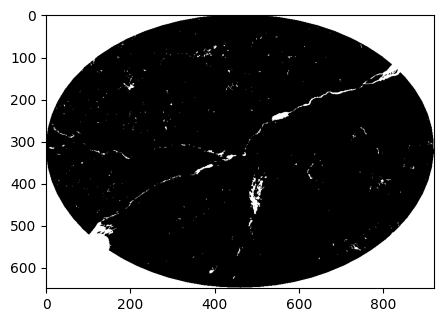

In [29]:
# Quick show of the clipped data according to the mask
plt.figure(figsize = (5,5))
plt.imshow(study_pop_np[0], cmap='Greys')

## Terres agricoles (données matricielles)

In [30]:
# Land raster file
file_name = 'Land_Canada.tif'

# Load land raster
land_raster = rasterio.open(f'{data_folder}/{file_name}')

# Check coordinate system
if land_raster.crs == 'None':
    print("Warning: loaded raster is missing CRS")

In [31]:
# Create a mask corresponding to the study area in the raster's coordinate system
study_mask = [json.loads(study_gdf.to_crs(land_raster.crs).to_json())['features'][0]['geometry']]

# Clip the raster with the mask
# The clipped output loses the geospatial information
# So we also save the geospatial information alongside
study_land_np, study_land_transform = rasterio.mask.mask(land_raster, study_mask, crop=True)

# Reintegrate geopspatial information
study_land_metadata = land_raster.meta # reuse the metadata from the original file
study_land_metadata.update({"driver": "GTiff",
                           "height": study_land_np.shape[1],
                           "width": study_land_np.shape[2],
                           "transform": study_land_transform})

# Save the clipped land cover raster (i.e. limited to the study area)
with rasterio.open(output_folder + "/Land_study.tif", "w", **study_land_metadata) as dest:
    dest.write(study_land_np)

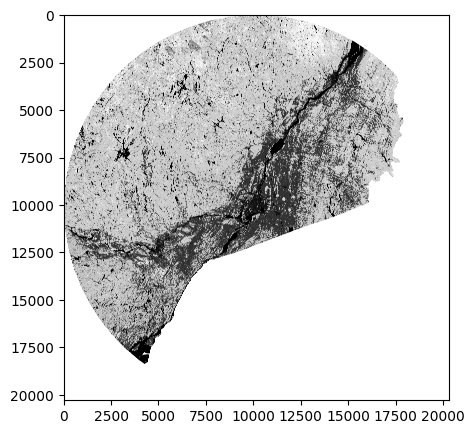

In [32]:
# Quick show of the clipped data according to the mask
plt.figure(figsize = (5,5))
plt.imshow(study_land_np[0], cmap='Greys')

## Données statistiques

**Données nutritionnelles**

In [303]:
# Human nutrition requirements (energy per day per capita)
daily_human_energy_kJ_req = {
    'minimum': 7536, # 1800 kilocalories = 7536 kJ
    'canada': 14930 # 3566 kilocalories = 14930 kJ
    }

Définition d'une fonction retournant la capacité d'autonomie nécessaire pour satisfaire un certain degré d'exigence en matière de nutrition.


In [309]:
def get_food_capacity_req(level):
    return round(daily_human_energy_kJ_req[level]/daily_human_energy_kJ_req['minimum']*100)

> Par exemple, pour les besoins minimum, la fonction retournera 100%, puisque c'est notre étalon (par définition une capacité d'autonomie est de 100% si le territoire couvre exactement les besoins minimum).

> Pour pouvoir assurer l'alimentation à des niveaux correspondant à la moyenne actuelle du Canada, il faudra ainsi viser une capacité d'autonomie supérieure, donnée par cette fonction en renseignant le niveau d'exigence `'canada'`.

**Données de productivité agricole**

In [34]:
# Food energy content (energy per mass)
# https://www.fao.org/3/y5022e/y5022e04.htm
food_energy = 17000 # kJ/kg (cereal)

# Food productivity (mass per surface per year)
annual_food_productivity = 3000 # kg/ha/year https://ourworldindata.org/crop-yields (FAO)

# Energy productivity (energy per surface per year) 
annual_energy_productivity = food_energy * annual_food_productivity # kJ/ha/year

# **Analyse préliminaire pour la zone d'étude**

**Population**

Chargement des données de population



In [35]:
# Population raster file for our study
file_name = 'Population_study.tif'

# Load population raster
study_pop_raster = rasterio.open(f'{output_folder}/{file_name}')

Calcul de la population

In [36]:
# Extract the population data from raster
pop_data = study_pop_raster.read()[0]

# Compute the total population present in the study area
study_pop = sum(pop_data[pop_data>=0])

# Print results
print(f"There are around {round(study_pop/1e6,1)} million inhabitants in the study area")

There are around 11.7 million inhabitants in the study area


**Terres agricoles**

Chargement des données de couverture du sol

In [79]:
# Population raster file for our study
file_name = 'Land_study.tif'

# Load population raster
study_land_raster = rasterio.open(f'{output_folder}/{file_name}')

On récupère les valeurs numériques qui représentent des terres agricoles dans le jeu de données de couverture du sol, ainsi que la résolution d'un pixel, pour pouvoir calculer la superficie des terres agricoles.

In [85]:
# Retrieve the codes associated to cropland in the data source
cropland_codes = str(data_sources_df[data_sources_df['Type']=='Land']['Cropland codes'].item()) # treat it as a string in case there are several codes
cropland_codes = cropland_codes.split(' ') # make it a list
cropland_codes = [float(item) for item in cropland_codes] # convert to numerical values

# Retrieve the pixel resolution from the data source information
pixel_resolution_m = data_sources_df[data_sources_df['Type']=='Land']['Resolution (m)'].item()

# Compute pixel area (m2)
pixel_area_m2 = pixel_resolution_m**2

Calcul de la superficie des terres agricoles

In [87]:
# Extract the land cover data from raster
land_data = study_land_raster.read()[0]

# Count cropland pixels
num_pixels_cropland = np.count_nonzero(land_data[np.isin(land_data,cropland_codes)])

# Compute cropland area
study_cropland_ha = round(pixel_area_m2 * num_pixels_cropland / 100**2)

print(f"There are {num_pixels_cropland} crop land pixels in the study area, representing a total of {study_cropland_ha} hectares")

There are 32571058 crop land pixels in the study area, representing a total of 2931395 hectares


**Evaluation de l'autonomie alimentaire globale**

In [100]:
# How much energy is needed by the population living on this territory?
# kJ/year
territory_energy_kJ_req = study_pop * annual_human_energy_kJ_req

# How much energy is produced on this territory?
# kJ/year
territory_energy_kJ_prod = study_cropland_ha * annual_energy_productivity

# Compute the level of food autonomy
print(f"The study area has an overall food autonomy level of {round(territory_energy_kJ_prod/territory_energy_kJ_req*100)}%.")

The study area has an overall food autonomy level of 464%.


# **Calcul de l'empreinte territoriale alimentaire**

Le but est de déterminer l'étendue géographique minimale nécessaire pour assurer l'autonomie alimentaire d'un territoire.

> Par autonomie alimentaire, on entend la capacité d'un territoire à produire suffisamment de nourriture pour nourrir correctement les habitants présents sur ce même territoire.

> On se base sur les évaluations fournies par l'OMS concernant les apports journaliers minimum recommandés, soit 1700 kcal par jour et par personne.

> Dans notre étude, un territoire qui permettrait d'atteindre ces recommandations pour l'ensemble des habitants possèderait par définition une capacité d'autonomie alimentaire de 100%.

## Quelques définitions 

Une fonction qui crée une zone circulaire de taille arbitraire stockée dans une GeoDataFrame.

In [117]:
################################################################################
# Function: get_circular_gdf
################################################################################
def get_circular_gdf(f_center_gdf, f_radius_km):

    # Create geometry
    circle_geometry = f_center_gdf.buffer(f_radius_km*1000, resolution=16)

    # Create geodataframe
    circle_gdf = gpd.GeoDataFrame(geometry=circle_geometry)

    # Provide the proper CRS to geodataframe
    circle_gdf.crs = f_center_gdf.crs

    return circle_gdf

## Algorithme de détermination
On a mis au point un algorithme itératif très simple, qui calcule l'autonomie alimentaire pour différentes tailles de territoire, jusqu'à trouver la taille minimale qui permet une capacité d'autonomie alimentaire donnée. 

**Principe**

Dans notre analyse, on considère un territoire circulaire autour d'un centre géographique (typiquement le centre d'une zone urbaine). De plus, la cible de capacité d'autonomie alimentaire est paramétrable pour faciliter la suite de l'analyse.

L'algorithme passe par deux phases distinctes:

1. Dans une première phase d'exploration, l'algorithme va essayer plusieurs tailles croissantes jusqu'à obtenir une borne supérieure, permettant d'assurer la cible qu'on s'est donnée en termes d'autonomie alimentaire.

2. Une fois la borne supérieure trouvée, l'algorithme entre dans une seconde phase, pour converger vers la taille recherchée (rayon en km), dans un intervalle d'une certaine précision (paramétrable). Cette phase de recherche se fait par une simple dichotomie.

D'une manière générale, pour un territoire de taille donnée (rayon R), voici les étapes de calcul:
* On crée un buffer circulaire de rayon R
* On calcule les besoins en nourriture du territoire
  * On crée un masque correspondant au territoire
  * On applique le masque aux données matricielles de population
  * On calcule la population présente
  * On calcule les besoins annuels en nourriture de cette population
* On calcule la production de nourriture du territoire
  * On crée un masque correspondant au territoire
  * On applique le masque aux données matricielles de couverture de sol
  * On calcule la superficie agricole
  * On calcule la production annuelle de nourriture
* On calcule la capacité d'autonomie alimentaire (ratio besoins/production)
* En fonction du résultat par rapport à notre cible, on ajuste la taille du territoire pour la prochaine itération.

In [391]:
################################################################################
# Function: dichotomic_search
################################################################################
def dichotomic_search(f_meas_value, f_meas_target, f_current_value, f_bounds):

    # Where are we compared to our desired target?
    if (f_meas_value < f_meas_target) and (f_current_value > f_bounds['lower']):
        # This is the new lower bound
        f_bounds['lower']= f_current_value  
    elif (f_meas_value >= f_meas_target) and (f_current_value < f_bounds['upper']):
        # This is the new upper bound
        f_bounds['upper']= f_current_value

    # Compute the offset to reach the middle of the new interval
    half_interval_offset = (f_bounds['upper'] - f_bounds['lower'])/2

    # Compute the next attempt
    next_value = round(f_bounds['lower'] + half_interval_offset,1)
    
    return next_value, f_bounds

################################################################################
# Function: compute_foodprint
# f_center : geodataframe for the center
# f_target: target autonomy for which to compute the corresponding radius
# f_precision_km: desired precision for the size found
# f_verbose_flag: print info about teh search process
# returns: a dictionnary containing the results
################################################################################
def compute_foodprint(f_center, f_target, f_precision_km, f_verbose_flag=False):

    # Search configuration
    search_radius_km = 5 # initial size to check

    # Search init
    search_flag = True
    search_counter = 0
    search_result_steps = []
    search_bounds_km = {'lower':0,'upper':-np.Inf}

    # Start search
    while (search_flag == True):

        # Create geodataframe for the current territory
        circle_gdf = get_circular_gdf(f_center, search_radius_km)

        ## POPULATION ##

        # Create mask for raster's coordinate system
        circle_mask = [json.loads(circle_gdf.to_crs(study_pop_raster.crs).to_json())['features'][0]['geometry']]

        # Extract the population data for the territory
        pop_data = rasterio.mask.mask(study_pop_raster, circle_mask, crop=True)[0]

        # Count population living on the territory
        territory_pop = round(sum(pop_data[pop_data>=0]))

        ## CROP LAND ##

        # Create mask for raster's coordinate system
        circle_mask = [json.loads(circle_gdf.to_crs(study_land_raster.crs).to_json())['features'][0]['geometry']]

        # Extract the land cover data for the territory
        land_data = rasterio.mask.mask(study_land_raster, circle_mask, crop=True)[0]

        # Count cropland pixels
        num_pixels_cropland = np.count_nonzero(land_data[land_data==cropland_codes])

        # Compute cropland area
        territory_cropland_ha = round(pixel_area_m2 * num_pixels_cropland / 100**2)

        ## FOOD AUTONOMY ANALYSIS ##

        # How much energy is needed by the population living on this territory? (kJ/year)
        territory_energy_kJ_req = territory_pop * daily_human_energy_kJ_req['minimum'] * 365

        # How much energy is produced on this territory? (kJ/year)
        territory_energy_kJ_prod = territory_cropland_ha * annual_energy_productivity

        # Compute food autonomy level
        food_autonomy_level = round(territory_energy_kJ_prod/territory_energy_kJ_req*100)

        ## RESULTS ##
        search_result_steps.append({
        'Radius (km)': search_radius_km,
        'Population (capita)': territory_pop,
        'Crop land (ha)': territory_cropland_ha,
        'Autonomy (%)': food_autonomy_level,
        })
        
        ## SEARCH ALGO #

        # Determine next iteration radius
        if search_bounds_km['upper'] <= search_bounds_km['lower']:
            # Exploration phase (no upper found yet)

            if (food_autonomy_level < f_target):
                
                # We found a new lower bound
                search_bounds_km['lower']=search_radius_km

                # We increase the radius
                search_radius_km *= 2
            else:
                
                # We found an upper bound
                search_bounds_km['upper']=search_radius_km

                # Determine next size to check
                search_radius_km, search_bounds_km = dichotomic_search(food_autonomy_level, f_target, search_radius_km, search_bounds_km)
            
        else: # time to converge between lower and upper bounds
            
            # Determine next size to check
            search_radius_km, search_bounds_km = dichotomic_search(food_autonomy_level, f_target, search_radius_km, search_bounds_km)

        # We print some information about this iteration
        if(f_verbose_flag == True):
            print(f"Iteration #{search_counter}\t Radius: {search_result_steps[search_counter]['Radius (km)']}km\t Autonomy: {search_result_steps[search_counter]['Autonomy (%)']}%")
            #print(f"Bounds:[{search_bounds_km['lower']}:{search_bounds_km['upper']}]\n")

        # Stop search if result has sufficient precision
        if abs(search_bounds_km['upper'] - search_bounds_km['lower']) <= f_precision_km:
            search_flag = False
        
        # next iteration
        search_counter+= 1

    # We return the search results, alongside with the corresponding geometry
    return {
           'city':f_center['Name'].item(),
           'autonomy':f_target,
           'radius':search_bounds_km['upper'],
           'geometry':f_center.buffer(search_bounds_km['upper']*1000, resolution=16).item()
           }


# Analyse de la capacité d'autonomie alimentaire d'un territoire


**Définition des centres urbains**

In [435]:
# Create a list of the urban centers to include in the study
cities_names = ["Montreal","Quebec"]

# Retrieve the coordinates of the cities
cities_coordinates = get_coordinates(cities_names)

# Create geometries from coordinates
cities_geometries = [Point(coordinates) for coordinates in cities_coordinates]

# Save information as geodataframe associating urban centers with their respective geometry
cities_gdf = gpd.GeoDataFrame({'Name': cities_names, 'geometry': cities_geometries}, geometry='geometry')

# Provide the coordinate system
cities_gdf.crs = geo_crs

# Project to the desired CRS
cities_gdf = cities_gdf.to_crs(study_crs)

## Analyse pour Montréal



**Empreinte minimale**

Calcul de l'étendue du territoire centré sur Montréal permettant d'atteindre une capacité d'autonomie alimentaire de 100%.

In [436]:
# All analysis results will be saved here
analysis_results = []

# Choose city
analysis_city_name='Montreal'

# Get the entry for that city
analysis_city = cities_gdf[cities_gdf['Name']==analysis_city_name]

# Find the territory corresponding to 100% autonomy
result = compute_foodprint(analysis_city, 100, 1, True)

# Save result
analysis_results.append(result)

# Print current search result
print(f"\n{result['city']} food autonomy territory has a reach of approximately {round(result['radius'])}km around the city center")

Iteration #0	 Radius: 5km	 Autonomy: 0%
Iteration #1	 Radius: 10km	 Autonomy: 0%
Iteration #2	 Radius: 20km	 Autonomy: 16%
Iteration #3	 Radius: 40km	 Autonomy: 107%
Iteration #4	 Radius: 30.0km	 Autonomy: 50%
Iteration #5	 Radius: 35.0km	 Autonomy: 75%
Iteration #6	 Radius: 37.5km	 Autonomy: 91%
Iteration #7	 Radius: 38.8km	 Autonomy: 100%
Iteration #8	 Radius: 38.1km	 Autonomy: 95%

Montreal food autonomy territory has a reach of approximately 39km around the city center


**Gradient d'autonomie territoriale alimentaire**

In [437]:
# Create a gradient table
autonomy_gradient = [get_food_capacity_req('canada'), round(get_food_capacity_req('canada')/0.43)]

for target_autonomy in autonomy_gradient:

    # Find the territory corresponding to 100% autonomy
    result = compute_foodprint(analysis_city, target_autonomy, 1)

    # Store results
    analysis_results.append(result)

On formate les résultats puis on les stocke dans une GeoDataFrame pour faciliter l'affichage par la suite.

In [438]:
def parse_results(results):

    # We convert the results to a format suited for GeoPandas
    results_parsed = [[item['city'],
                item['autonomy'],
                item['radius'],
                item['geometry']] for item in results]

    return results_parsed

# Create a GeoDataFrame with the analysis results so far
analysis_results_gdf = gpd.GeoDataFrame(data=parse_results(analysis_results), columns=['city','autonomy','radius','geometry'])
analysis_results_gdf.crs = analysis_city.crs

**Affichage des résultats**

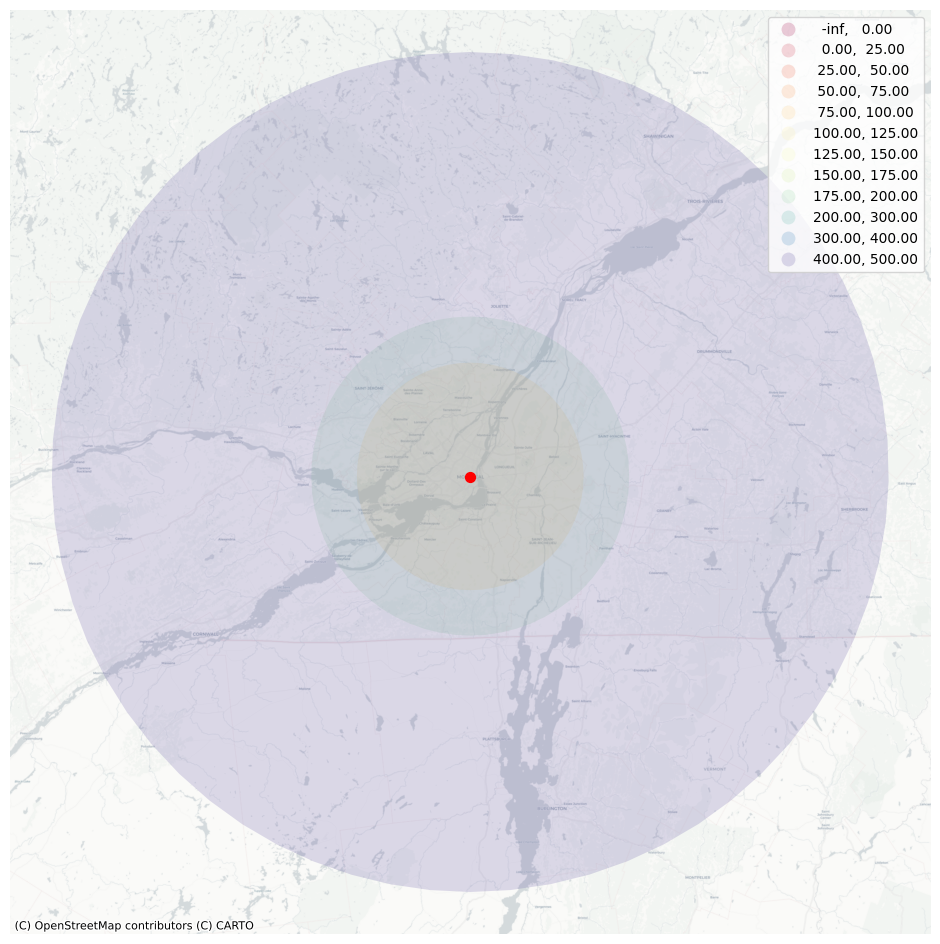

In [381]:
# Show a chloropleth map for the level of autonomy
base = analysis_results_gdf.to_crs(plot_crs).plot(
                column='autonomy', 
                cmap='Spectral', 
                scheme='user_defined', 
                classification_kwds={'bins':[0,25,50,75,100,125,150,175,200,300,400,500]},
                legend=True,
                figsize=(12, 12), 
                alpha=0.2, 
                zorder=1)

# Add the city
cities_gdf[cities_gdf['Name']==analysis_city_name].to_crs(plot_crs).plot(
                ax=base, 
                marker='o', 
                color='red', 
                markersize=50,
                zorder=2,)

# Add a background map
cx.add_basemap(ax=base,
               zoom=10,
               source=cx.providers.CartoDB.Positron) # différents styles : https://geopandas.org/en/stable/gallery/plotting_basemap_background.html

# Remove the axis
base.set_axis_off()

# Export the image
plt.savefig(output_folder + "/Results_study.png", dpi=300)

## Analyse pour les principales villes du Québec et des alentours

In [440]:
# Store the name of the city whose analysis was done in the previous section
previous_analysis_city_name = analysis_city_name

# For every from the list of cities to consider in our study
for index, row in cities_gdf.iterrows():

    # Get the name of the city we consider here
    current_city_name = row['Name']

    # Get geodataframe for current city only
    current_city = cities_gdf[cities_gdf['Name']==current_city_name]

    # Let's not repeat the analysis for city that was already chosen in the previous analysis
    if current_city_name != previous_analysis_city_name:

        # For all other cities, perform the same analysis
        for target_autonomy in autonomy_gradient:

            # Find the territory corresponding to 100% autonomy
            result = compute_foodprint(current_city, target_autonomy, 1)

            # Store results
            analysis_results.append(result)

In [442]:
# Create a GeoDataFrame with the analysis results
analysis_results_gdf = gpd.GeoDataFrame(data=parse_results(analysis_results), columns=['city','autonomy','radius','geometry'])
analysis_results_gdf.crs = analysis_city.crs

# Export results
analysis_results_gdf.to_csv(output_folder + "/Results_study.csv")

**Affichage des résultats**

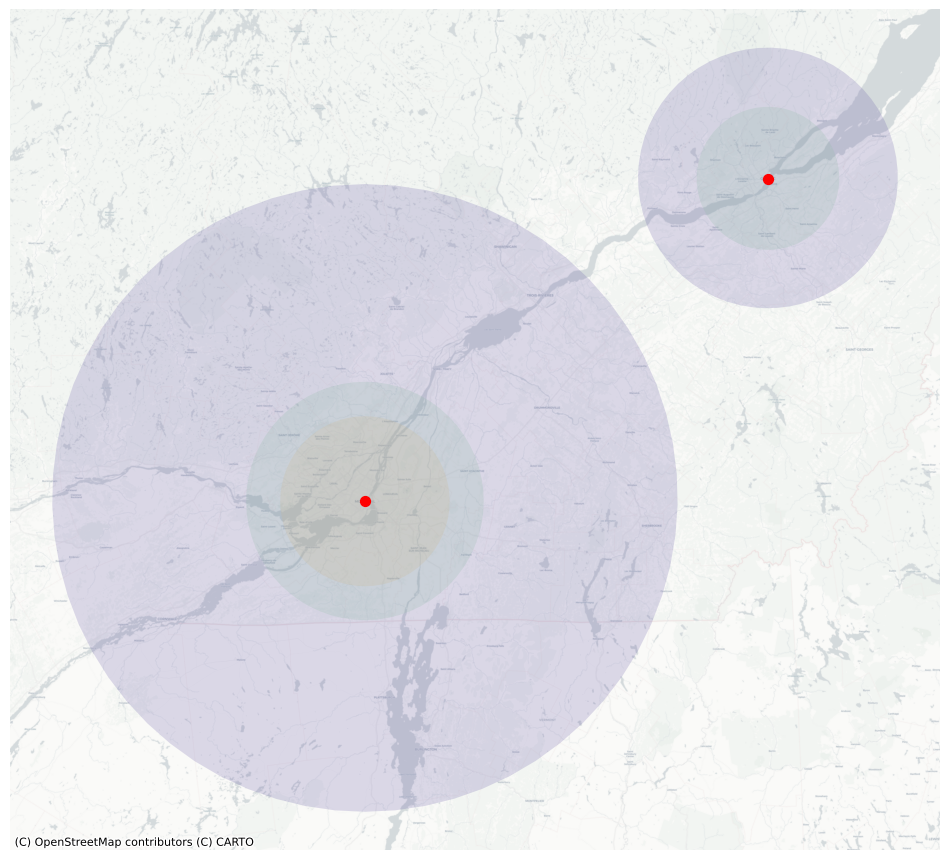

In [444]:
# Show a chloropleth map for the level of autonomy
base = analysis_results_gdf.to_crs(plot_crs).plot(
                column='autonomy', 
                cmap='Spectral', 
                scheme='user_defined', 
                classification_kwds={'bins':[0,25,50,75,100,125,150,175,200,300,400,500]},
                legend=False,
                figsize=(12, 12), 
                alpha=0.2, 
                zorder=1)

# Add the cities
cities_gdf.to_crs(plot_crs).plot(
                ax=base, 
                marker='o', 
                color='red', 
                markersize=50,
                zorder=2,)

# Add a background map
cx.add_basemap(ax=base,
               zoom=10,
               source=cx.providers.CartoDB.Positron) # différents styles : https://geopandas.org/en/stable/gallery/plotting_basemap_background.html

# Remove the axis
base.set_axis_off()

# Export the image
plt.savefig(output_folder + "/Results_study_final.png", dpi=300)